In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

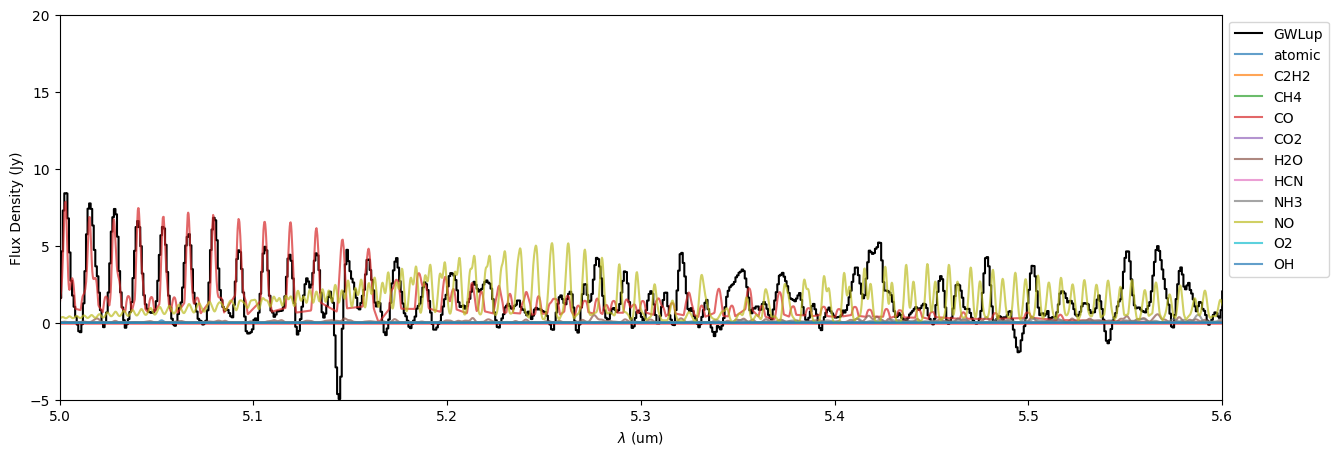

10657


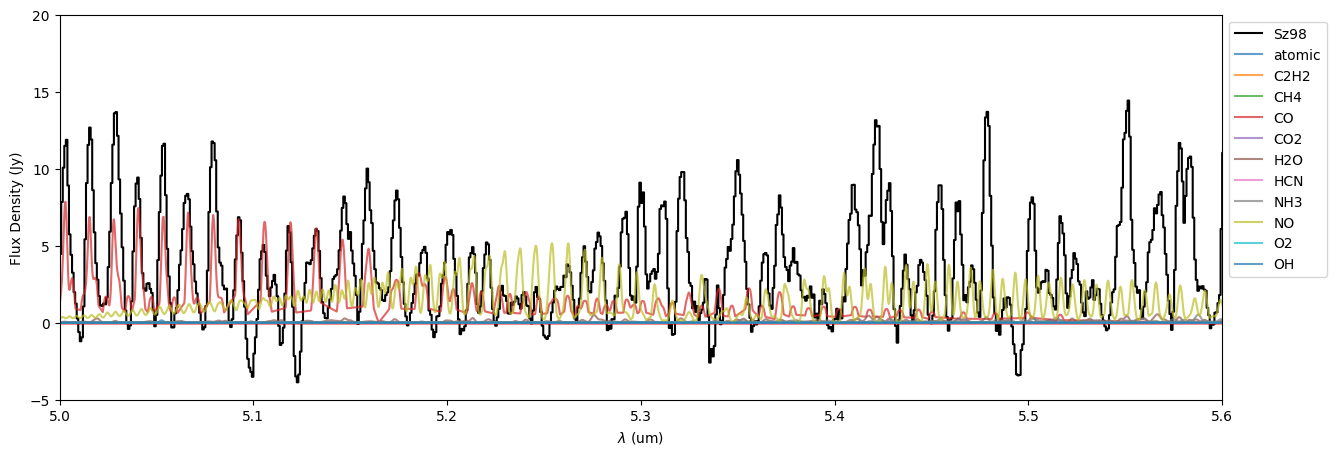

10657


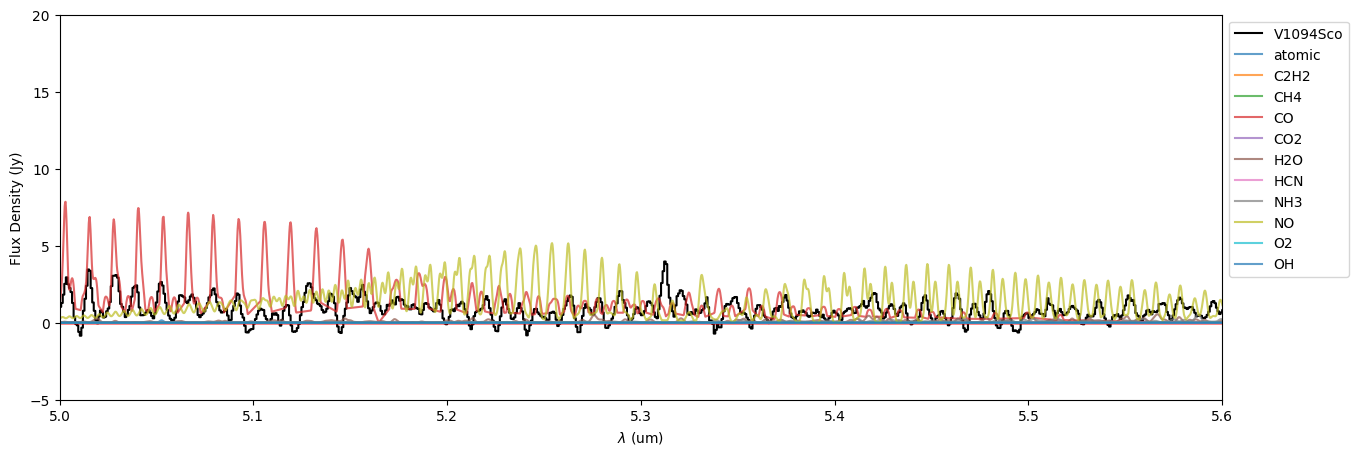

10657


In [51]:
features_df = pd.read_csv("matthias_linelist_combined.csv")

# Wavelength grid
clip_min, clip_max = 5, 5.6
feature_mask = np.logical_and(features_df['wavelength'] > clip_min, features_df['wavelength'] < clip_max)


# fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']
    ax1.step(wavelength, np.convolve(flux_cont_sub, np.ones(5)/5, mode='same')*1000, color='black',where='mid', label=f'{Source}')
    for index, row in features_df[feature_mask].iterrows():
        if row['type'] == 'hydrogen':
            color = 'purple'
            offset = 0.05
        elif row['type'] == 'fine_structure':
            color = 'orange'
            offset = 0.4
        elif row['type'] == 'molecular':
            color = 'blue'
            offset = 0.05
        else:
            color = 'red'
            offset = 0.6
        ax1.axhline(0,  color='red')
        # ax1.axvline(row['wavelength'], linestyle='--', alpha=0.3, color=color)
        # ax1.text(row['wavelength']+0.004, offset, row['name'], transform=ax1.get_xaxis_text1_transform(0)[0], color=color, rotation=90)

    for specie in species:
        ax1.plot(total_wl, avg_flux[specie], alpha=0.7, label=specie)

    # plot decorations
    # ax1.set_xticks([14.9, 14.95, 15])
    ax1.set_xlim(clip_min, clip_max)    
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_xlabel(r'$\lambda$ (um)')
    ax1.set_ylim(-5, 20)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    print(len(wavelength))

In [10]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [212]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
avg_flux = {}
total_wl = wavelength
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= 25
    avg_flux.update({specie:total_flux})

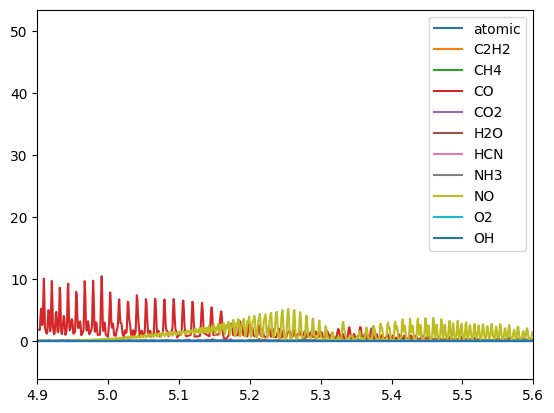

In [119]:
for specie in species:
    plt.plot(total_wl, avg_flux[specie], label=specie)
plt.legend()
plt.xlim(4.9, 5.6)
plt.show()

[1.10338016 0.93641204 0.999991   1.         0.98836612 0.18554608
 0.96384491 0.45031231 0.17107918 1.00094698]


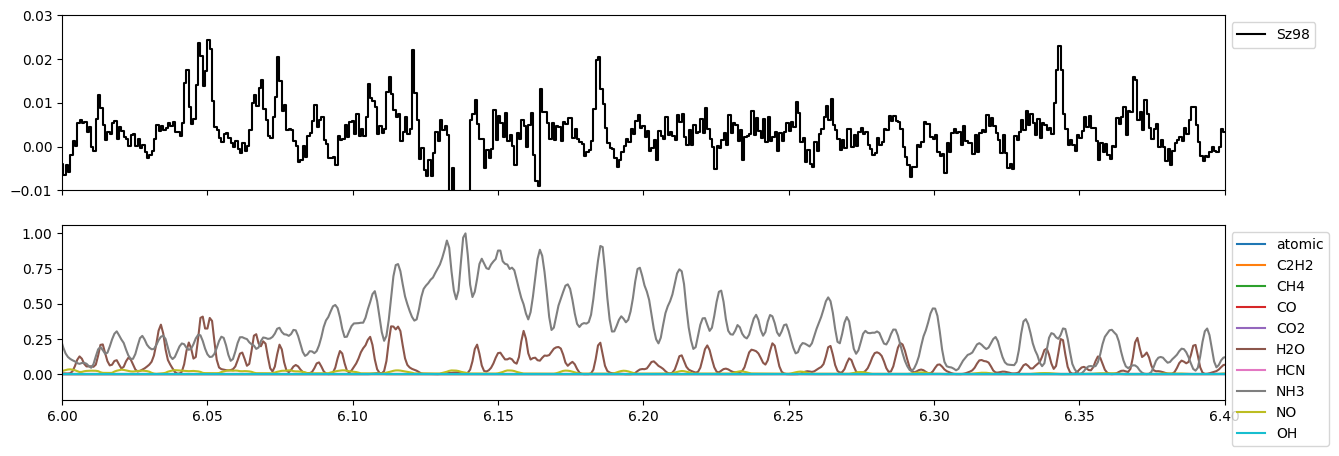

In [271]:
from scipy.optimize import minimize

clip_min, clip_max = 6, 6.4
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
def model(params):
    total = np.zeros_like(total_wl)
    for i, specie in enumerate(species):
        total += params[i] * avg_flux[specie]
    return total


def loss(params):
    if any(param < 0 for param in params):
        return 1e10
    return np.sum((model(params) - flux_cont_sub)[feature_mask] ** 2)


Source = ['GWLup', 'Sz98', 'V1094Sco'][1]
file = f'FullSpectrum_CS_{Source}.p'
data = pickle.load(open(file, 'rb'))
wavelength = data['Wavelength']
flux = data['Flux']
flux_cont_sub = data['CSFlux']
continuum = data['Baseline']

result = minimize(loss, [1]*len(species))
best_params = result.x
print(best_params)
y_fit = model(best_params)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
# plt.figure(figsize=(15, 5))
# ax1.plot(wavelength, model(best_params), color='red')
# for i, specie in enumerate(species):
#     ax1.fill_between(total_wl, 0, best_params[i] * avg_flux[specie], label=specie)
ax1.step(wavelength, flux_cont_sub, color='black', label=Source)
ax1.set_xlim(clip_min, clip_max)
ax1.set_ylim(-0.01, 0.03)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()
# plt.figure(figsize=(15, 5))
for specie in species:
    ax2.plot(total_wl, avg_flux[specie]/max(avg_flux[specie]), label=specie)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax2.set_ylim(0, 0.1)
plt.show()